In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# 全局設置
plt.rcParams.update(
    {
        # image
        "figure.figsize": (10, 6),
        "figure.dpi": 100,
        # grid
        "grid.alpha": 0.7,
        "grid.linestyle": "--",
        # font
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        # legend
        "legend.fontsize": 10,
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.shadow": False,
        # other
        "axes.grid": True,  # 默認顯示網格
        "figure.autolayout": True,  # 自動調整布局
    }
)

In [ ]:
# load the ROBOD dataset for each room
room_names = ["Room1", "Room2", "Room3", "Room4", "Room5"]
data_dict = {}
for room in room_names:
    data_dict[room] = {}
    data_dict[room]["raw"] = pd.read_csv("./data/ROBOD/combined_{}.csv".format(room))

In [4]:
occu_data_avg = {}
occu_data = {}
for i in range(len(room_names)):
    # load data and preprocess columns
    room_name = room_names[i]
    data = data_dict[room_name]["raw"]
    data[["date", "time", "utc_offset"]] = data["timestamp"].str.split(" ", expand=True)
    for i in range(len(room_names)):
        # load data and preprocess columns
        room_name = room_names[i]
        data = data_dict[room_name]["raw"]
        data[["date", "time", "utc_offset"]] = data["timestamp"].str.split(
            " ", expand=True
        )
        data = data.rename(columns={"occupant_count [number]": "occupancy"})
        occu_data[room_name] = data["occupancy"].values
        # calculate average occupancy on average weekday
        all_dates = data["date"].unique()
        tmp_array = np.zeros((len(all_dates), 288))
        for j in range(len(all_dates)):
            tmp_array[j, :] = data[data["date"] == all_dates[j]][
                "occupancy"
            ].values.reshape(1, -1)
        occupancy_data = tmp_array.mean(axis=0)
        occu_data_avg[room_name] = occupancy_data

In [ ]:
# concatenate all occupancy data
occu_data_all = np.concatenate(
    [occu_data[room_name] for room_name in room_names], axis=0
)
# remove 0 values since they are not valid
occu_data_all = occu_data_all[occu_data_all != 0]

In [490]:
import random

import scipy.optimize as optimize
import scipy.stats as stats
from sklearn.neighbors import KernelDensity
from torch import rand

# fix random seed for reproducibility
# np.random.seed(42)
# random.seed(42)

# fit kernel density estimator to obtain a gamma distribution
kde = KernelDensity(bandwidth="scott", kernel="gaussian")
kde.fit(occu_data_all.reshape(-1, 1))
# print fitted parameters
# sample from the fitted distribution to our data size and convert to integer values
data_size = 47430
occu_data_sample = kde.sample(data_size).flatten()
# convert to integer values

# convert to integer values
# replace occupancy values greater than 17 with random integer values from 1 to 17
mask_occu_data_sample = occu_data_sample > 17
occu_data_sample[mask_occu_data_sample] = np.random.randint(
    1, 18, mask_occu_data_sample.sum()
)
# replace occupancy values less than 1 with random integer values from 1 to 17
mask_occu_data_sample = occu_data_sample < 1
occu_data_sample[mask_occu_data_sample] = np.random.randint(
    1, 18, mask_occu_data_sample.sum()
)


occu_data_sample_pic = kde.sample(occu_data_all.size).flatten()
# convert to integer values
occu_data_sample_pic = occu_data_sample_pic.astype(int)

# replace occupancy values greater than 17 with random integer values from 1 to 17
mask_occu_data_sample_pic = occu_data_sample_pic > 17
occu_data_sample_pic[mask_occu_data_sample_pic] = np.random.randint(
    1, 18, mask_occu_data_sample_pic.sum()
)
# replace occupancy values less than 1 with random integer values from 1 to 17
mask_occu_data_sample_pic = occu_data_sample_pic < 1
occu_data_sample_pic[mask_occu_data_sample_pic] = np.random.randint(
    1, 18, mask_occu_data_sample_pic.sum()
)


def compute_chi_square(observed_freq, expected_freq):
    """計算卡方統計量"""
    valid_bins = expected_freq >= 5
    return np.sum(
        (observed_freq[valid_bins] - expected_freq[valid_bins]) ** 2
        / expected_freq[valid_bins]
    )


# raw data fitting
kde = KernelDensity(bandwidth="scott", kernel="gaussian")
kde.fit(occu_data_all.reshape(-1, 1))

# calculate expected frequency
x_grid = np.arange(1, 40).reshape(-1, 1)
log_dens = kde.score_samples(x_grid)
dens = np.exp(log_dens)
expected_freq = dens * len(occu_data_all) / np.sum(dens)  # 歸一化

# calculate observed frequency
observed_freq = np.histogram(occu_data_all, bins=range(1, 41))[0]

# calculate chi-square statistic for the original data
original_chi_square = compute_chi_square(observed_freq, expected_freq)

# bootstrap
n_bootstrap = 1000
bootstrap_chi_squares = []

for _ in range(n_bootstrap):
    # Sample from the fitted KDE
    bootstrap_sample = np.exp(kde.sample(len(occu_data_all)))

    # Fit a KDE to the bootstrap sample
    bootstrap_kde = KernelDensity(bandwidth="scott", kernel="gaussian")
    bootstrap_kde.fit(bootstrap_sample)

    # calculate expected frequency for the bootstrap sample
    log_dens_boot = bootstrap_kde.score_samples(x_grid)
    dens_boot = np.exp(log_dens_boot)
    expected_freq_boot = dens_boot * len(occu_data_all) / np.sum(dens_boot)

    # calculate observed frequency for the bootstrap sample
    observed_freq_boot = np.histogram(bootstrap_sample, bins=range(1, 41))[0]

    # calculate chi-square statistic for the bootstrap sample
    chi_square_boot = compute_chi_square(observed_freq_boot, expected_freq_boot)
    bootstrap_chi_squares.append(chi_square_boot)

# calculate p-value
p_value = np.mean(np.array(bootstrap_chi_squares) >= original_chi_square)

# 輸出結果
print("\n=== KDE fitting and Bootstrap ===")
print(f"Original Chi-square statistic: {original_chi_square:.4f}")
print(f"Bootstrap p-value: {p_value:.4f}")


=== KDE fitting and Bootstrap ===
Original Chi-square statistic: 0.0000
Bootstrap p-value: 1.0000


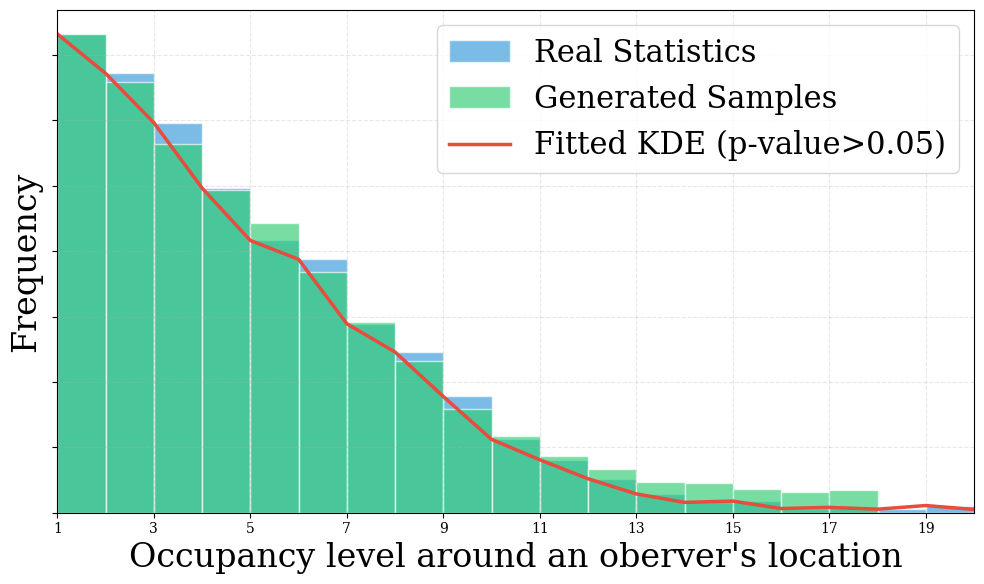

In [512]:
fig_occu, ax = plt.subplots()
plt.rcParams["font.family"] = ["DejaVu Serif"]
ax.hist(
    occu_data_all,
    bins=range(1, 40),
    alpha=0.65,
    label="Real Statistics",
    color="#3498DB",  # use blue color
    edgecolor="white",
    linewidth=1,
)
ax.hist(
    occu_data_sample_pic,
    bins=range(1, 40),
    alpha=0.65,
    label="Generated Samples",
    color="#2ECC71",  # use green color
    edgecolor="white",
    linewidth=1,
)
ax.plot(
    x_grid,
    expected_freq,
    color="#E74C3C",  # use red color
    lw=2.5,
    label="Fitted KDE (p-value>0.05)",
)
ax.grid(True, linestyle="--", alpha=0.3)
ax.set_xlim(1, 20)
ax.set_xticks(range(1, 20, 2))
ax.set_yticklabels([])
ax.set_xlabel("Occupancy level around an oberver's location", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)
ax.legend(frameon=True, fancybox=True, fontsize=22, loc="upper right")
plt.tight_layout()
plt.show()

In [513]:
# save the figure
fig_occu.savefig(
    "./data/Figure/occupancy_distribution.pdf",
    bbox_inches="tight",
    format="pdf",
)

In [220]:
# save the sampled occupancy data
# sort the data from smallest to largest
occu_data_sample = occu_data_sample.astype(int)
np.savetxt("./data/occu_data_sample.csv", occu_data_sample, delimiter=",")

In [19]:
rir_manifest = pd.read_csv("./data/RIR_aggregated/RIR.metadata/RIRLabelAugmentV2.csv")

In [29]:
# creat a uniform distribution of occupancy data
np.random.seed(42)
data_size = 47430
occu_data_uniform = np.random.randint(1, 18, data_size)
# covert to integer values
occu_data_uniform = occu_data_uniform.astype(int)

# save the uniform occupancy data
np.savetxt("./data/occu_data_uniform.csv", occu_data_uniform, delimiter=",")

In [30]:
occu_data_uniform

array([ 7, 15, 11, ..., 12, 16,  3])

In [31]:
# Based on the volume, set different occupancy limits
import ast

import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
num_occu_sampled = occu_data_uniform  # or occu_data_sample
occu_all = []
rir_volume = rir_manifest["volume"].apply(
    lambda x: torch.tensor(ast.literal_eval(x)).prod().round(decimals=0).item()
)
for i in range(len(rir_volume)):
    if rir_volume[i] < 400:
        # obtain occupancy less than 5 and corresponding indices
        indices = np.where(num_occu_sampled < 7)[0]
        # choose one of the indices randomly
        if indices.size == 0:  # empty sequence
            idx = random.choice(range(len(num_occu_sampled)))
        else:
            idx = random.choice(indices)
        occu_all.append(num_occu_sampled[idx])
        # remove this index from the list
        num_occu_sampled = np.delete(num_occu_sampled, idx)
    elif rir_volume[i] >= 400 and rir_volume[i] < 2000:
        # obtain occupancy less than 10 and corresponding indices
        indices = np.where(num_occu_sampled < 12)[0]
        # choose one of the indices randomly
        if indices.size == 0:  # empty sequence
            idx = random.choice(range(len(num_occu_sampled)))
        else:
            idx = random.choice(indices)
        occu_all.append(num_occu_sampled[idx])
        # remove this index from the list
        num_occu_sampled = np.delete(num_occu_sampled, idx)
    elif rir_volume[i] >= 2000 and rir_volume[i] < 4000:
        # obtain occupancy less than 15 and corresponding indices
        indices = np.where(num_occu_sampled < 15)[0]
        # choose one of the indices randomly
        if indices.size == 0:  # empty sequence
            idx = random.choice(range(len(num_occu_sampled)))
        else:
            idx = random.choice(indices)
        occu_all.append(num_occu_sampled[idx])
        # remove this index from the list
        num_occu_sampled = np.delete(num_occu_sampled, idx)
    elif rir_volume[i] >= 4000:
        # obtain occupancy less than 20 and corresponding indices
        indices = np.where(num_occu_sampled < 18)[0]
        # choose one of the indices randomly
        if indices.size == 0:  # empty sequence
            idx = random.choice(range(len(num_occu_sampled)))
        else:
            idx = random.choice(indices)
        occu_all.append(num_occu_sampled[idx])
        # remove this index from the list
        num_occu_sampled = np.delete(num_occu_sampled, idx)

In [ ]:
num_occu = pd.DataFrame(
    {
        "num_occ": occu_all,
        "rir_volume": rir_volume,
    }
)
num_occu.to_csv(
    "./data/RIR_aggregated/RIR.metadata/num_occu.csv",
    index=False,
)

In [32]:
num_occu = pd.DataFrame(
    {
        "num_occ": occu_all,
        "rir_volume": rir_volume,
    }
)
num_occu.to_csv(
    "./data/RIR_aggregated/RIR.metadata/num_occu_uniform.csv",
    index=False,
)

Gamma distribution shape: 6.18024685913397
Gamma distribution scale: 18.667382195345333


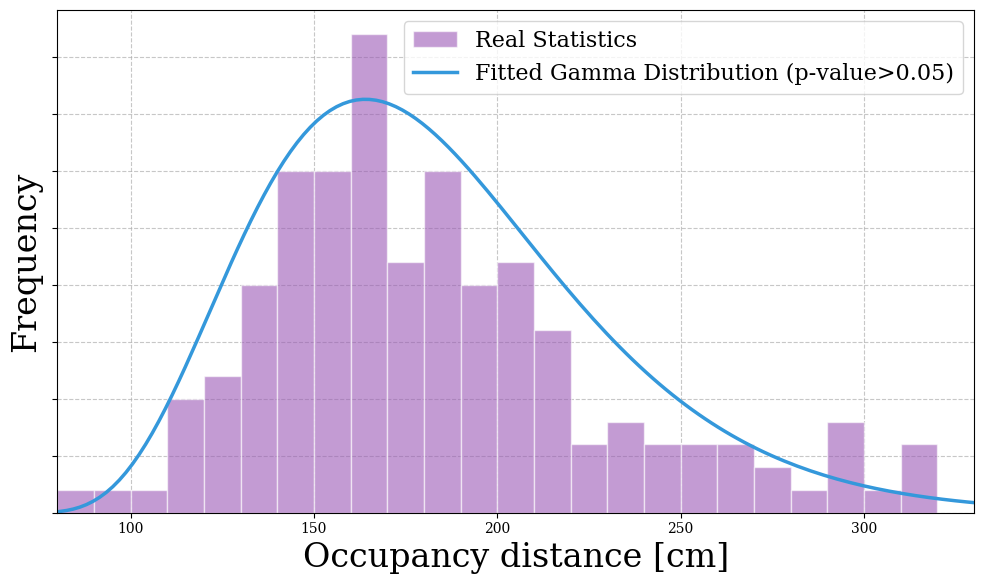

In [ ]:
import scipy.stats as stats  # noqa: F811

# occupancy distance raw data from STRASS2023
distance_strass = np.array(
    [
        126.88461538461539,
        163.07407407407408,
        180.26939655172413,
        176.4026622296173,
        170.0800821355236,
        110.58471454880295,
        187.45833333333334,
        148.37476459510358,
        250.54666666666665,
        141.72009029345372,
        176.73076923076923,
        161.800933125972,
        149.3564814814815,
        267.9097065462754,
        163.11012861736336,
        135.07676767676767,
        140.16803278688525,
        165.44970414201183,
        307.8636363636364,
        165.8631284916201,
        243.11764705882354,
        114.65552995391705,
        195.56617647058823,
        150.52315394242802,
        149.29517502365184,
        182.23121387283237,
        167.12391930835736,
        124.9261744966443,
        155.33668341708542,
        162.3903345724907,
        151.05719557195573,
        129.68191489361703,
        188.87154696132598,
        150.32018561484918,
        147.0152354570637,
        212.55339805825244,
        113.01290322580645,
        164.5485380116959,
        162.37008959338388,
        170.39716312056737,
        252.36989032901297,
        127.08689458689459,
        292.7353279631761,
        310.6,
        144.7409200968523,
        294.51724137931035,
        163.3575129533679,
        289.85,
        172.36630036630038,
        311.28205128205127,
        229.53571428571428,
        241.0,
        252.38086124401914,
        180.3846153846154,
        179.06545454545454,
        131.8653846153846,
        275.009324009324,
        156.67979669631512,
        167.18045112781954,
        144.22577209797657,
        172.3174061433447,
        311.85114503816794,
        294.1954022988506,
        151.8421052631579,
        264.9255172413793,
        166.43543543543544,
        207.29525483304042,
        158.751269035533,
        167.1747899159664,
        167.57557251908398,
        146.18775510204082,
        165.59240506329115,
        145.2424778761062,
        183.718,
        157.1582981985435,
        170.78556701030928,
        210.47916666666666,
        203.33242258652095,
        260.9622775800712,
        279.68445839874414,
        138.15981735159818,
        144.6366153846154,
        151.97577092511014,
        136.286800276434,
        205.8740740740741,
        133.94758339006125,
        149.68176538908247,
        137.52712591471106,
        140.46595744680852,
        181.94059405940595,
        88.75443786982248,
        290.9302469135802,
        150.42093023255813,
        164.88536585365853,
        131.30721649484536,
        151.7602568676418,
        178.50864779874215,
        186.6295652173913,
        168.82084690553745,
        154.45934379457918,
        183.4560810810811,
        184.64344262295083,
        148.764,
        225.60073839662448,
        123.51810237203496,
        213.9825581395349,
        202.78953421506614,
        167.8732484076433,
        155.71574468085106,
        208.66497461928935,
        129.40227136879855,
        205.4754966887417,
        177.42382271468145,
        221.76,
        215.1216931216931,
        201.87002518891688,
        233.03764705882352,
        167.36208991494533,
        165.32768978700165,
        183.17821782178217,
        151.19044459190445,
        188.5952818627451,
        151.2453680520781,
        116.08885298869144,
        231.51659192825113,
        195.30616822429906,
        186.2724770642202,
        142.63006535947713,
        207.0609022556391,
        134.71336405529954,
        244.63549783549783,
        181.44210526315788,
        207.9284,
        193.6090909090909,
        172.1620512820513,
        217.00052056220719,
        198.69493087557603,
        201.66092715231787,
        215.4906103286385,
        166.29718255499807,
        139.34766763848395,
        196.83645320197044,
        213.24848484848485,
        138.9558985667034,
        214.55249569707402,
        117.39111922141119,
        236.17371048252912,
        196.25514950166112,
        190.7258543833581,
        107.68409586056644,
        184.66492146596858,
        196.2943231441048,
        190.90052356020942,
        191.39607843137256,
        97.775,
        201.55347985347984,
        239.00904522613067,
    ]
)

# apply IQR to remove outliers
# Q1 = np.percentile(distance_strass, 25)
# Q3 = np.percentile(distance_strass, 75)

# IQR = Q3 - Q1
# distance_strass = distance_strass[
#     (distance_strass > (Q1 - 1.5 * IQR)) & (distance_strass < (Q3 + 1.5 * IQR))
# ]


# # fit a Gamma distribution to the sampled data
params_dist = stats.gamma.fit(distance_strass)
# fit a mixture of Gaussians to the occupancy distance data
# gmm = mixture.GaussianMixture(n_components=2)
# gmm.fit(distance_strass.reshape(-1, 1))
# sample from the fitted distribution to our data size with different upper and lower bounds [1, 6]
# data_size = 47430
# distance_strass_sample = gmm.sample(distance_strass.size)[0].flatten()
distance_strass_sample = stats.gamma.rvs(*params_dist, size=distance_strass.size)
# print fitted parameters
print(f"Gamma distribution shape: {params_dist[0]}")
print(f"Gamma distribution scale: {params_dist[2]}")
# print(f"Means of Gaussian Mixture: \n{gmm.means_.round(2)}")
# print(f"Variances of Gaussian Mixture: \n{gmm.covariances_.round(2)}")

# using the calculated mean and variance, plot the fitted distribution
x1 = np.linspace(70, 350, distance_strass.size)
y1 = stats.gamma.pdf(x1, *params_dist)
# y1 = np.exp(
#     gmm.score_samples(x1.reshape(-1, 1))
# )  # use the score_samples method to get the pdf


# plot histogram of occupancy distance and fitted distribution
fig_dist, ax = plt.subplots()
plt.rcParams["font.family"] = ["DejaVu Serif"]
ax.hist(
    distance_strass,
    bins=range(70, 350, 10),
    alpha=0.6,
    label="Real Statistics",
    color="#9B59B6",
    edgecolor="white",
    linewidth=1,
    zorder=2,
)
ax.plot(
    x1,
    y1 * distance_strass.size * 12.5,
    label="Fitted Gamma Distribution (p-value>0.05)",
    color="#3498DB",  # use green color
    linewidth=2.5,  # 加粗線條
    linestyle="-",
)
ax.set_yticklabels([])
ax.set_xlim(80, 330)
ax.set_xlabel("Occupancy distance [cm]", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)
ax.legend(frameon=True, fancybox=True, fontsize=16, loc="upper right")
plt.tight_layout()

In [510]:
fig_dist.savefig(
    "./data/Figure/occupancy_distance_distribution.pdf",
    bbox_inches="tight",
    format="pdf",
)

In [384]:
# ks test for goodness of fit for Gamma distribution
# perform the Kolmogorov-Smirnov test
ks_stat, p_val = stats.kstest(distance_strass, "gamma", args=params_dist)
# print the results true value is p, round to 2 decimal places
print("KS test p-value: " + str(round(p_val, 4)))

KS test p-value: 0.7411


In [385]:
# # test chi-square goodness of fit
# 如果要進行 chi-square 測試，需要確保頻率總和相等
# 計算觀察頻率
observed_freq, bins = np.histogram(
    distance_strass, bins=range(70, 350, 10), density=False
)
# 計算期望頻率
bin_centers = (bins[1:] + bins[:-1]) / 2
expected_prob = stats.gamma.pdf(bin_centers, *params_dist)
expected_freq = expected_prob * distance_strass.size * 13.5
# 確保總和相等
expected_freq = expected_freq * (sum(observed_freq) / sum(expected_freq))
chi2, p = stats.chisquare(observed_freq, expected_freq)
# critical value for chi-square test
alpha = 0.05
critical_value = stats.chi2.ppf(1 - alpha, len(observed_freq) - 1)
print(f"Critical value: {critical_value.round(2)}")
print(f"Chi-square: {chi2.round(2)}")
print(f"p-value: {(p).round(2)}")

Critical value: 38.89
Chi-square: 32.77
p-value: 0.17
